## Predicting Song Popularity with Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from random import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from random import shuffle
import random
random.seed(123)

### Preprocess Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4831 entries, 0 to 4830
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   energy             4831 non-null   float64
 1   tempo              4831 non-null   float64
 2   danceability       4831 non-null   float64
 3   playlist_genre     4831 non-null   object 
 4   loudness           4831 non-null   float64
 5   valence            4831 non-null   float64
 6   track_artist       4831 non-null   object 
 7   speechiness        4831 non-null   float64
 8   instrumentalness   4831 non-null   float64
 9   mode               4831 non-null   float64
 10  key                4831 non-null   float64
 11  duration_ms        4831 non-null   float64
 12  acousticness       4831 non-null   float64
 13  playlist_subgenre  4831 non-null   object 
 14  popularity         4831 non-null   int64  
dtypes: float64(11), int64(1), object(3)
memory usage: 566.3+ KB


<Axes: xlabel='popularity'>

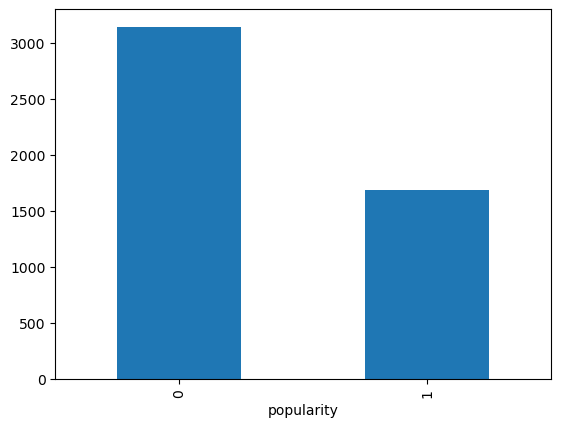

In [3]:
# load data
high_popularity = pd.read_csv("high_popularity_spotify_data.csv")
low_popularity = pd.read_csv("low_popularity_spotify_data.csv")

high_popularity['popularity'] = 1  # High popularity tracks
low_popularity['popularity'] = 0   # Low popularity tracks

original_data = pd.concat([high_popularity, low_popularity], ignore_index=True)

# drop irrelevant columns from both datasets
features_dropped = ['id', 'track_album_id', 'playlist_name', 'liveness', 'time_signature',
                    'track_href', 'uri', 'analysis_url', 'playlist_id', 'track_id', 'type',
                    'track_name', 'track_album_name', 'track_popularity', 'track_album_release_date']

df = original_data.drop(columns = features_dropped)

# missing values
df.isnull().sum()

# select numerical features and fill missing values with median
numeric_cols = df.select_dtypes(include = ['float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# select categorical features and fill missing values with new category: 'unknown'
categorical_cols = df.select_dtypes(include = ['object']).columns
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

df.isnull().sum() 
# successful; all values are 0

# categorical features
df.info() # track_artist, track_album_release_date, playlist_genre, and playlist_subgenre are categorical
df = pd.get_dummies(df, columns=['playlist_genre', 'track_artist', 'playlist_subgenre'], drop_first=True)
df.head()

df['popularity'].value_counts().plot(kind = 'bar')   # data is imbalanced; data consists of a lot more low popularity tracks than high popularity tracks

### Model Training 

In [7]:
# Split data into train and testing sets
features = df.drop('popularity', axis = 1).values
popularity = df['popularity'].values

X_train_val, X_test, Y_train_val, Y_test = train_test_split(features, popularity, test_size = 0.1, random_state = 0)

num_train_val = X_train_val.shape[0]
num_test = X_test.shape[0]
print("train: {}, test: {}".format(num_train_val, num_test))

# Normalize features
normalizer = StandardScaler()
X_train_val = normalizer.fit_transform(X_train_val)
X_test = normalizer.transform(X_test)

# Model Training
folds = 9

# shuffle index of samples in train set
index_of_samples = np.arange(num_train_val)
shuffle(index_of_samples)

# split the index of the train set into 9 folds
index_of_folds = index_of_samples.reshape(folds, -1)

regularization_coefficient = [10**-3, 10**-2, 10**-1, 1, 10, 20, 50, 100]

best_f1 = 0.0
best_reg = 0.0

for reg in regularization_coefficient: 
    
    sum_f1 = 0.0
    
    for fold in range(folds):
        
        index_of_folds_temp = index_of_folds.copy()

        valid_index = index_of_folds_temp[fold,:].reshape(-1)
        train_index = np.delete(index_of_folds_temp, fold, 0).reshape(-1)

        # training set
        X_train = X_train_val[train_index]
        Y_train = Y_train_val[train_index]

        # validation set
        X_valid = X_train_val[valid_index]
        Y_valid = Y_train_val[valid_index]
        
        clf = LogisticRegression(penalty = 'l2', C = reg, solver = 'lbfgs', max_iter = 200, class_weight='balanced')
        
        # train the model with the training set
        clf.fit(X_train, Y_train)
        
        Y_valid_pred = clf.predict(X_valid)
        f1 = f1_score(Y_valid, Y_valid_pred)
        
        sum_f1 += f1
    
    cur_f1 = sum_f1 / folds
    
    print("reg_coeff: {}, f1: {:.3f}".format(1.0/reg, cur_f1))
    
    # store the best hyperparameter
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        best_reg = reg

train: 4347, test: 484
reg_coeff: 1000.0, f1: 0.809
reg_coeff: 100.0, f1: 0.809
reg_coeff: 10.0, f1: 0.789
reg_coeff: 1.0, f1: 0.764
reg_coeff: 0.1, f1: 0.725
reg_coeff: 0.05, f1: 0.711
reg_coeff: 0.02, f1: 0.675
reg_coeff: 0.01, f1: 0.665


### Evaluation

Coefficients: [[ 0.14495132  0.03079663  0.09816387 ...  0.05355423 -0.04207428
  -0.05300589]]
Intercept: [-0.95865154]
recall: 0.835, precision: 0.813, f1: 0.824


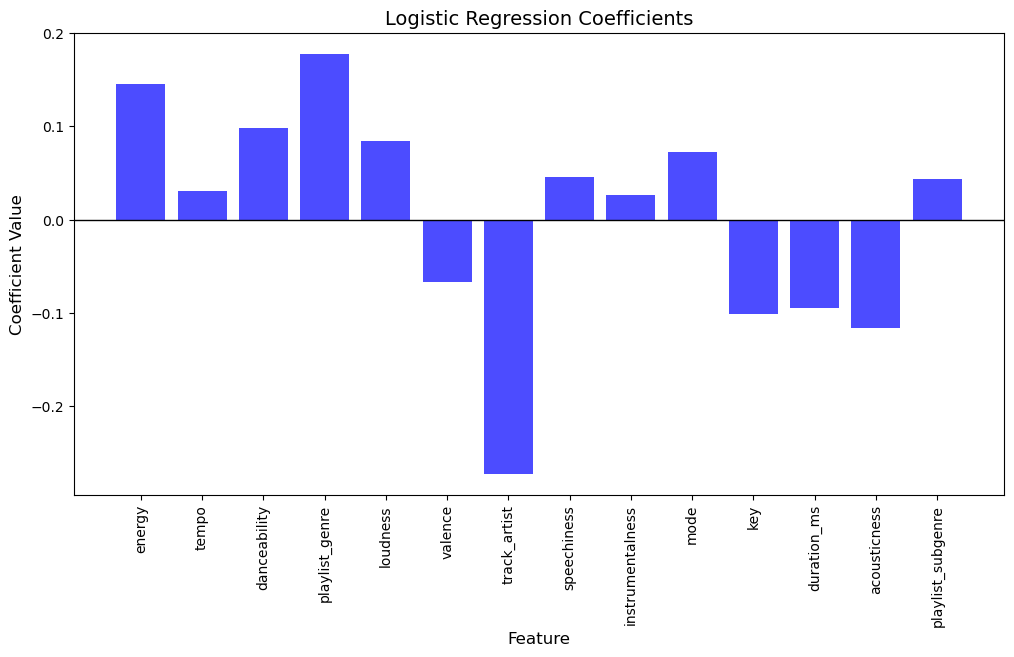

In [10]:
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# get the model with the best hyperparameter
clf = LogisticRegression(penalty = 'l2', C = best_reg, solver = 'lbfgs', max_iter = 200, class_weight='balanced')
clf.fit(X_train_val, Y_train_val)

# coefficients and intercept
print("Coefficients:", clf.coef_)
print("Intercept:", clf.intercept_)

# evaluate the model on the testing set
Y_test_pred = clf.predict(X_test)

f1 = f1_score(Y_test, Y_test_pred)
recall = recall_score(Y_test, Y_test_pred)
precision = precision_score(Y_test, Y_test_pred)

print("recall: {:.3f}, precision: {:.3f}, f1: {:.3f}".format(recall, precision, f1))

M = original_data.drop(columns = features_dropped)
M = M.drop(columns=['popularity'])
coefficients = clf.coef_.flatten()[:len(M.columns)]

plt.figure(figsize=(12, 6))
plt.bar(M.columns, coefficients, color='b', alpha=0.7)
plt.axhline(0, color='black', linewidth=1)
plt.xlabel('Feature', fontsize = 12)
plt.ylabel('Coefficient Value', fontsize = 12)
plt.title('Logistic Regression Coefficients', fontsize=14)
plt.xticks(rotation=90)
plt.show()